In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from scripts_ml.ann_utils import *

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2236762600885230091
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1449056665
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5433857802768909125
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-02-20_p180_bg_'
valid_code = '_val_26000_2000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1812'
postfix_time_seq = '_190824_1321'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_p180"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [4]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.models import Sequential

In [5]:
#recombining folds for grid search

val_X_all = []
val_y_all = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_all.append(list(val_X_train[idx[0]]))
    val_y_all.append(list(val_y_train[idx[0]]))
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    #val_X_all.append(list(val_X_test[test_idx]))
    #val_y_all.append(list(val_y_test[test_idx]))
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1

In [6]:
X = np.array(val_X_all[1:]).reshape((26000,7,35))
#y = np.array([val_X_all[1]])
X.shape

(26000, 7, 35)

In [7]:
y = np.array(val_y_all[1:]).reshape((26000,7,1))
y.shape

(26000, 7, 1)

In [8]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [9]:
cw = class_weight.compute_sample_weight({False:1, True:50},#'balanced',
                                                 #np.unique(y_train),
                                                 y.flatten())

In [10]:
model = Sequential()
#model.add(SimpleRNN(X.shape[2], return_sequences=True))
#model.add(SimpleRNN(X.shape[2], return_sequences=True))
#model.add(SimpleRNN(X.shape[2], return_sequences=True))
model.add(LSTM(160, return_sequences=True, dropout=0.05))
model.add(LSTM(80, return_sequences=True, dropout=0.05, activation='relu'))
model.add(LSTM(40, return_sequences=True, dropout=0.05, activation='relu'))
model.add(LSTM(10, return_sequences=True, dropout=0.05))
#model.add(LSTM(X.shape[2], return_sequences=True))
#model.add(LSTM(X.shape[2], return_sequences=True))
#model.add(LSTM(X.shape[2], return_sequences=True))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC()], sample_weight_mode="temporal")

In [11]:
#model.build(X.shape)
#model.summary()

In [13]:
with tf.device("/device:GPU:0"):
    model.fit(X, y, epochs=500, batch_size=4096, verbose=1, sample_weight=cw.reshape(26000,7,1),shuffle=False) #validation_split=0.2, 

ValueError: Found a sample_weight array with shape (26000, 7, 1). In order to use timestep-wise sample weights, you should specify sample_weight_mode="temporal" in compile(). If you just mean to use sample-wise weights, make sure your sample_weight array is 1D.

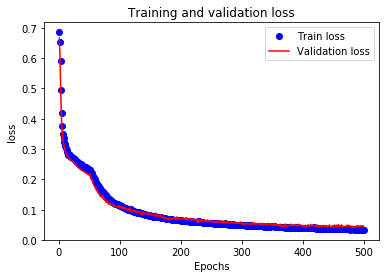

In [33]:
history = model.history.history
plot_epochs_graph(history, 'loss', True)

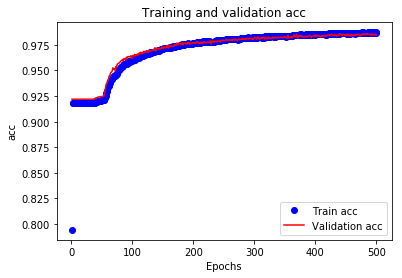

In [34]:
plot_epochs_graph(history, 'acc', True)

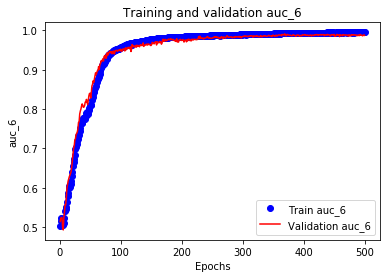

In [36]:
plot_epochs_graph(history, 'auc_6', True)

In [37]:
y_scores = model.predict(X_test.reshape(15540,1,35))

In [38]:
y_scores = y_scores.flatten()

In [39]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc=roc_auc_score(y_test, y_scores)
print("AUC {:.3f}".format(auc))

AUC 0.801
